In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install xlrd
!pip install bs4
!pip install tmdbv3api
!pip install nltk
!pip install gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
import pickle
style.use('seaborn-poster')
style.use('ggplot')


from bs4 import BeautifulSoup
import requests
import os

from tmdbv3api import TMDb
from tmdbv3api import Movie
tmdb = TMDb()
tmdb.api_key = '14dec12dedde4ad68a8707bdf54d04ab'

import pandas as pd
import numpy as np
import pickle
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from gensim.models import KeyedVectors


from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
###import training images normalized 
with open('/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/train_np_imgs_norm','rb') as f: X_img_train = pickle.load(f)
X_img_train.shape

(3357, 115, 75, 3)

In [ ]:
with open('/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/test_np_imgs_norm', 'rb') as f: X_img_test = pickle.load(f)
X_img_test.shape

(932, 115, 75, 3)

In [ ]:
with open('/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/val_np_img_norm', 'rb') as f: X_img_val = pickle.load(f)
X_img_val.shape

(374, 115, 75, 3)

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/dataset_mod.csv")
train = pd.read_csv("/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/train_data.csv")
test = pd.read_csv("/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/test_data.csv")
val = pd.read_csv("/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/val_data.csv")

In [ ]:
train

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,original_title,overview,id,genres,genre_list,vote_average,keywords,production_companies,cast,crew,poster_paths
0,0,0,2006,Harley Davidson and the Marlboro Man,"In the near future, Harley Davidson (Mickey Ro...",2453,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","['Action', 'Thriller']",6.1,0.443444,0.396552,0.417056,0.355693,/content/drive/My Drive/MovieContent/dataset/p...
1,1,1,276,Harry Potter and the Chamber of Secrets,Harry Potter spends the summer with the Dursle...,672,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","['Adventure', 'Fantasy', 'Family']",7.4,0.674443,0.623964,0.836174,0.776111,/content/drive/My Drive/MovieContent/dataset/p...
2,2,2,1701,Die Hard,"NYPD cop, John McClane's plan to reconcile wit...",562,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","['Action', 'Thriller']",7.5,0.536658,0.549452,0.787999,0.505982,/content/drive/My Drive/MovieContent/dataset/p...
3,3,3,242,Fantastic Four,Childhood friends Reed Richards and Ben Grimm ...,166424,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","['Action', 'Adventure', 'Science Fiction']",4.4,0.256157,0.435445,0.480667,0.478273,/content/drive/My Drive/MovieContent/dataset/p...
4,4,4,3845,D.E.B.S.,Embedded in the SAT is a secret test that dete...,540,"[{""id"": 28, ""name"": ""Action""}]",['Action'],5.6,0.218949,0.361718,0.288552,0.276291,/content/drive/My Drive/MovieContent/dataset/p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,3352,3352,1271,Pandorum,Two crew members wake up on an abandoned space...,19898,"[{""id"": 28, ""name"": ""Action""}, {""id"": 27, ""nam...","['Action', 'Horror', 'Mystery', 'Science Ficti...",6.5,0.508579,0.464515,0.522980,0.532326,/content/drive/My Drive/MovieContent/dataset/p...
3353,3353,3353,2498,Enter the Void,Oscar (Nathaniel Brown) lives in Tokyo with hi...,34647,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 18, ""na...","['Fantasy', 'Drama']",7.2,0.625006,0.627907,0.792710,0.775920,/content/drive/My Drive/MovieContent/dataset/p...
3354,3354,3354,4557,12 Angry Men,In the overheated jury room of the New York Co...,389,"[{""id"": 18, ""name"": ""Drama""}]",['Drama'],8.2,0.868468,0.841219,0.908860,0.969589,/content/drive/My Drive/MovieContent/dataset/p...
3355,3355,3355,692,Chicken Little,"In the small town of Oakey Oaks, which is popu...",9982,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...","['Animation', 'Family', 'Comedy']",5.6,0.369826,0.659082,0.396626,0.425799,/content/drive/My Drive/MovieContent/dataset/p...


In [ ]:
maxvote = train["vote_average"].max()
train_labels = train["vote_average"] / maxvote
test_labels = test["vote_average"] / maxvote
val_labels = val["vote_average"] / maxvote

In [ ]:
train_labels.count

<bound method Series.count of 0       0.61
1       0.74
2       0.75
3       0.44
4       0.56
        ... 
3352    0.65
3353    0.72
3354    0.82
3355    0.56
3356    0.65
Name: vote_average, Length: 3357, dtype: float64>

In [ ]:
train_labels.count

<bound method Series.count of 0       0.61
1       0.74
2       0.75
3       0.44
4       0.56
        ... 
3352    0.65
3353    0.72
3354    0.82
3355    0.56
3356    0.65
Name: vote_average, Length: 3357, dtype: float64>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def prepare_categ_columns(train,test,val):
    continuous = ['keywords', 'production_companies','cast', 'crew']
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous  = cs.transform(test[continuous])
    valContinuous  =  cs.transform(val[continuous])
    ##print('test')
    train_categ = np.hstack([trainContinuous])
    test_categ  = np.hstack([testContinuous])
    val_categ   = np.hstack([valContinuous])
    return (train_categ, test_categ,val_categ) 

In [ ]:
(X_categ_train, X_categ_test,X_categ_val) = prepare_categ_columns(train, test,val)

In [ ]:
print(X_categ_train.shape,    X_categ_test.shape,   X_categ_val.shape)
print(X_categ_train.shape[1], X_categ_test.shape[1],X_categ_val.shape[1])
print(X_categ_train.shape[0], X_categ_test.shape[0],X_categ_val.shape[0])

(3357, 4) (932, 4) (374, 4)
4 4 4
3357 932 374


In [ ]:
X_categ_train

array([[0.44344419, 0.39606742, 0.41705564, 0.35527847],
       [0.67444301, 0.62366239, 0.83617377, 0.77625667],
       [0.53665802, 0.54909042, 0.78799852, 0.50576831],
       ...,
       [0.86846764, 0.84109149, 0.90885999, 0.96999297],
       [0.36982631, 0.65880819, 0.39662621, 0.42547823],
       [0.36591824, 0.61867978, 0.57716941, 0.66916211]])

In [ ]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])
  text = re.sub(r"\s{2,}", " ", text)
  return text

train['overview'] = train['overview'].astype(str)
test['overview'] = test['overview'].astype(str)
val['overview'] = val['overview'].astype(str)

train['overview'] = train['overview'].apply(lambda text: clean_text(text))
test['overview'] = test['overview'].apply(lambda text: clean_text(text))
val['overview'] = val['overview'].apply(lambda text: clean_text(text))

In [ ]:

dataset['overview'] = dataset['overview'].astype(str)
dataset['overview'] = dataset['overview'].apply(lambda text: clean_text(text))

In [ ]:
dataset['overview']

0       human depleted earth natural resource leading ...
1       order control ocean lord cutler beckett execut...
2       posthumous message previous lead agent james b...
3       bane mysterious terrorist former member league...
4       edgar rice burroughs attends funeral uncle joh...
                              ...                        
4659    two engineer aaron abe supplement dayjobs entr...
4660    breaking jail small mexican town ruthless crim...
4661    honeymoon period end quickly buzzy burn katie ...
4662    signed sealed delivered introduces dedicated q...
4663    ever since second grade first saw et extraterr...
Name: overview, Length: 4664, dtype: object

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = dataset['overview'].map(len).max()
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(dataset['overview'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', MAX_SEQUENCE_LENGTH)

Found 57064 unique tokens.
Max len: 8190


In [ ]:
def get_embedding_matrix(typeToLoad):
  if typeToLoad == "glove":
    EMBEDDING_FILE="/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/glove.6B.100d.txt"
    embed_size = 100
  elif typeToLoad == "word2vec":
    word2vecDict = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/glove.6B.100d.txt", binary=True)
    embed_size = 300
  elif typeToLoad == "fasttext":
    EMBEDDING_FILE="../wiki-news-300d-1M.vec"
    embed_size = 100

  if typeToLoad == "glove"or typeToLoad == "fasttext":
    embeddings_index = dict()
    f = open('/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/glove.6B.100d.txt', encoding="utf8")
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
  else:
    embeddings_index = dict()
    for word in word2vecDict.wv.vocab:
      embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
        
  del(embeddings_index)
        
  return embedding_matrix

In [ ]:
word2vec_embedding_matrix = get_embedding_matrix("glove")

Loaded 400000 word vectors.
total embedded: 43780 common words


In [ ]:
word2vec_embedding_matrix.shape

(57065, 100)

In [ ]:
X_text_train = tokenizer.texts_to_sequences(train['overview'].values)
X_text_train = pad_sequences(X_text_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_train.shape)

Shape of train tensor: (3357, 8190)


In [ ]:

X_text_test = tokenizer.texts_to_sequences(test['overview'].values)
X_text_test = pad_sequences(X_text_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_test.shape)

Shape of train tensor: (932, 8190)


In [ ]:
X_text_val = tokenizer.texts_to_sequences(val['overview'].values)
X_text_val = pad_sequences(X_text_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_val.shape)

Shape of train tensor: (374, 8190)


In [ ]:
type(train_labels[1])

numpy.float64

In [ ]:
import pickle
with open('/content/drive/MyDrive/New_Approach_7_Movie_Content_Sagemaker/MovieContent/X_text_train','wb') as f: pickle.dump(X_text_train, f)

In [ ]:
import pickle
with open('/content/drive/My Drive/ForShashank/X_text_test','wb') as f: pickle.dump(X_text_test, f)

In [ ]:
import pickle
with open('/content/drive/My Drive/ForShashank/X_text_val','wb') as f: pickle.dump(X_text_val, f)

In [ ]:
with open('/content/drive/My Drive/ForShashank/X_categ_train','wb') as f: pickle.dump(X_categ_train, f)


In [ ]:
with open('/content/drive/My Drive/ForShashank/X_categ_test','wb') as f: pickle.dump(X_categ_test, f)


In [ ]:
with open('/content/drive/My Drive/ForShashank/X_categ_val','wb') as f: pickle.dump(X_categ_val, f)

LOAD THE TRAIN TEST and VAL

In [ ]:
def compile_model():
  embedding_matrix = word2vec_embedding_matrix
  lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=MAX_SEQUENCE_LENGTH, trainable=False)(lstm_input)
  x = Dropout(0.3)(x)
  x = LSTM(64, return_sequences = True)(x)
  x = Dropout(0.3)(x)
  lstm_out = LSTM(64)(x)
  ##x = Dropout(0.3)(x)
  ##lstm_out = Dense(1, activation = 'relu')(x)

  print(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
  cnn_input = Input(shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))
  y = Conv2D(32, (3, 3), activation='relu', input_shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))(cnn_input)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(64, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Flatten()(y)
  y = Dropout(0.3)(y)
  cnn_out = Dense(512, activation='relu')(y)


  print(X_categ_train.shape[1])
  cnn2_input = Input(shape=(X_categ_train.shape[1],))
  p = Dense(4, activation='relu')(cnn2_input)
  p = Dropout(0.3)(p)
  cnn2_out = Dense(4, activation='relu')(p)
  ##cnn2_out = Dense(1, activation='linear')(p)

  print('concat')
  concat_inp = concatenate([cnn_out, lstm_out,cnn2_out])
  z = Dense(256, activation='relu')(concat_inp)
  z = Dropout(0.3)(z)
  z = Dense(128, activation='relu')(z)
  z = Dropout(0.3)(z)
  ####Optimizer 
  output = Dense(1, activation='sigmoid')(z)

  print('concat')
  model = Model(inputs=[cnn_input, lstm_input,cnn2_input], outputs=[output])
  adam = Adam(lr=1e-3, decay=1e-3 / 200) ###Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mae', 'mse'])   ##binary_crossentropy, removed accuracy as the metric
  return model

In [ ]:
stacked_model7 = compile_model()
stacked_model7.summary()

115 75 3
4
concat
concat
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 115, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 73, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 36, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 34, 64)   18496       max_pooling2d[0][0]              
_____________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
14/14 [==============================] - 613s 43s/step - loss: 15.0093 - mae: 0.0887 - mse: 0.0124 - val_loss: 14.8189 - val_mae: 0.0759 - val_mse: 0.0096
Epoch 2/50
14/14 [==============================] - 613s 44s/step - loss: 13.4509 - mae: 0.0772 - mse: 0.0097 - val_loss: 14.6799 - val_mae: 0.0771 - val_mse: 0.0098
Epoch 3/50
14/14 [==============================] - 620s 45s/step - loss: 13.2806 - mae: 0.0761 - mse: 0.0094 - val_loss: 14.5580 - val_mae: 0.0757 - val_mse: 0.0094
Epoch 4/50
14/14 [==============================] - 625s 45s/step - loss: 13.0876 - mae: 0.0751 - mse: 0.0092 - val_loss: 14.6971 - val_mae: 0.0778 - val_mse: 0.0098
Epoch 5/50
14/14 [==============================] - 618s 44s/step - loss: 13.0318 - mae: 0.0747 - mse: 0.0091 - val_loss: 14.5523 - val_mae: 0.0759 - val_mse: 0.0094
Epoch 6/50
14/14 [==============================] - 606s 44s/step - loss: 12.8854 - mae: 0.0738 - mse: 0.0090 - val_loss: 14.5798 - val_mae: 0.0763 - val_mse: 0.0094
Epoc

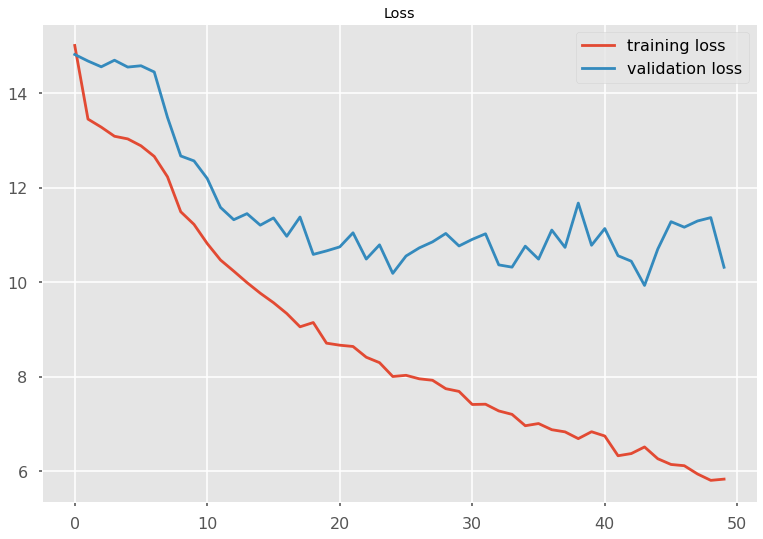

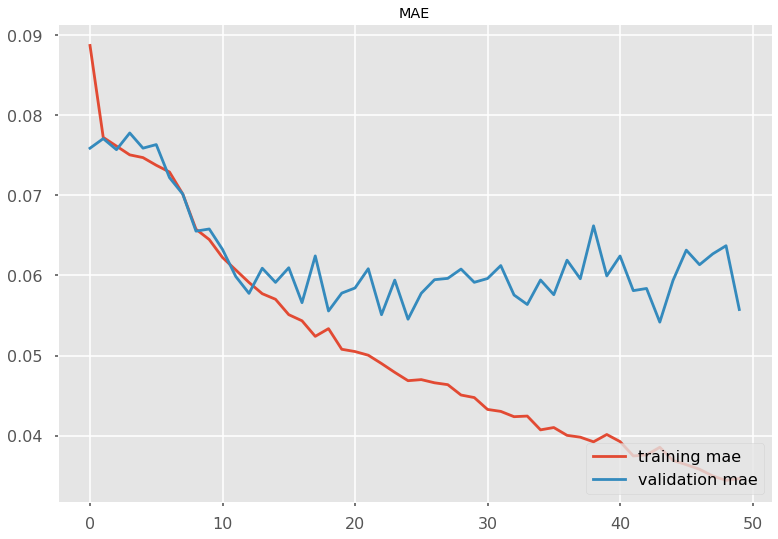

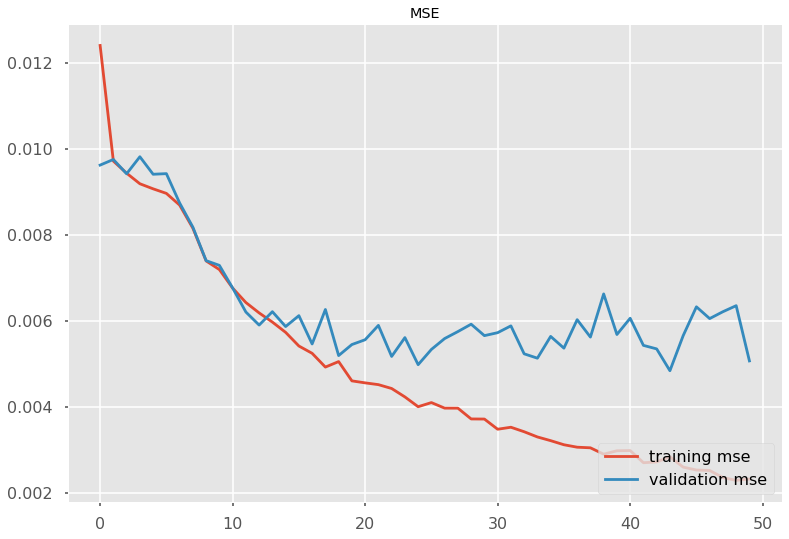

In [26]:
seed = 7
np.random.seed(seed)
X_img = X_img_train
X_text = X_text_train
X_categ = X_categ_train
y = train_labels

history = stacked_model7.fit([X_img, X_text,X_categ], 
                                 train_labels, 
                                 batch_size=256, 
                                 epochs=50,
                                 validation_data=([X_img_test,X_text_test,X_categ_test], test_labels)
                                )

print("[INFO] predicting avg votes...")
preds = stacked_model7.predict([X_img_val, X_text_val,X_categ_val])


from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
print('mean_absolute_error = ',mean_absolute_error(val_labels, preds))
print('mean_squared_error  = ',mean_squared_error(val_labels, preds))
print('r2_score            = ',r2_score(val_labels, preds))


def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_mae(history):
  plt.title('MAE')
  plt.plot(history.history['mae'], label='train')
  plt.plot(history.history['val_mae'], label='test')
  plt.legend(['training mae', 'validation mae'], loc='lower right')
  plt.show()

def plot_mse(history):
  plt.title('MSE')
  plt.plot(history.history['mse'], label='train')
  plt.plot(history.history['val_mse'], label='test')
  plt.legend(['training mse', 'validation mse'], loc='lower right')
  plt.show()


plot_loss(history)
plot_mae(history)
plot_mse(history)

In [1]:
seed = 7
np.random.seed(seed)
X_img = X_img_train
X_text = X_text_train
X_categ = X_categ_train
y = train_labels

history = stacked_model7.fit([X_img, X_text,X_categ], 
                                 train_labels, 
                                 batch_size=256, 
                                 epochs=100,
                                 validation_data=([X_img_test,X_text_test,X_categ_test], test_labels)
                                )

print("[INFO] predicting avg votes...")
preds = stacked_model7.predict([X_img_val, X_text_val,X_categ_val])


from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
print('mean_absolute_error = ',mean_absolute_error(val_labels, preds))
print('mean_squared_error  = ',mean_squared_error(val_labels, preds))
print('r2_score            = ',r2_score(val_labels, preds))


def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_mae(history):
  plt.title('MAE')
  plt.plot(history.history['mae'], label='train')
  plt.plot(history.history['val_mae'], label='test')
  plt.legend(['training mae', 'validation mae'], loc='lower right')
  plt.show()

def plot_mse(history):
  plt.title('MSE')
  plt.plot(history.history['mse'], label='train')
  plt.plot(history.history['val_mse'], label='test')
  plt.legend(['training mse', 'validation mse'], loc='lower right')
  plt.show()


plot_loss(history)
plot_mae(history)
plot_mse(history)

NameError: ignored

In [ ]:
##from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold    

seed = 7
np.random.seed(seed)
X_img = X_img_train
X_text = X_text_train
X_categ = X_categ_train
y = train_labels

cvsLoss = []
cvsMAE = []
cvsMSE = []

rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=36851234)

for train_index, test_index in (rskf.split(X_img, np.zeros(shape=(X_img.shape[0], 1)))) :
    ##print("TRAIN:", train_index, "TEST:", test_index,type(train_index),'---',len(train_index),'---',type(train_index),'---------',len(test_index))

    X_train_img, X_test_img = X_img[train_index], X_img[test_index]
    X_train_text, X_test_text = X_text[train_index], X_text[test_index]
    X_train_categ, X_test_categ = X_categ[train_index], X_categ[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    history = stacked_model7.fit([X_train_img, X_train_text,X_train_categ], 
                                 y_train, 
                                 batch_size=100, 
                                 epochs=5,
                                 validation_data=([X_test_img,X_test_text,X_test_categ], y_test)
                                )
    ##scores = stacked_model7.evaluate([X_test_img,X_test_text,X_test_categ], y_test, verbose=1)
    ###print("%s: %.2f%%" % (stacked_model7.metrics_names[0],stacked_model7.metrics_names[1],stacked_model7.metrics_names[2] )
    cvsLoss.append(stacked_model7.metrics_names[0])
    cvsMAE.append(stacked_model7.metrics_names[1])
    cvsMSE.append(stacked_model7.metrics_names[2])

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Train on 2237 samples, validate on 1119 samples
Epoch 1/5
2237/2237 [==============================] - 630s 282ms/step - loss: 33.0174 - mae: 0.2191 - mse: 0.0749 - val_loss: 13.5326 - val_mae: 0.0901 - val_mse: 0.0106
Epoch 2/5
2237/2237 [==============================] - 677s 303ms/step - loss: 14.2713 - mae: 0.0939 - mse: 0.0139 - val_loss: 6.7442 - val_mae: 0.0424 - val_mse: 0.0028
Epoch 3/5
2237/2237 [==============================] - 668s 299ms/step - loss: 12.3879 - mae: 0.0815 - mse: 0.0105 - val_loss: 8.6915 - val_mae: 0.0562 - val_mse: 0.0045
Epoch 4/5
2237/2237 [==============================] - 672s 300ms/step - loss: 11.7110 - mae: 0.0771 - mse: 0.0094 - val_loss: 8.5530 - val_mae: 0.0554 - val_mse: 0.0043
Epoch 5/5
2237/2237 [==============================] - 674s 301ms/step - loss: 11.0672 - mae: 0.0725 - mse: 0.0083 - val_loss: 5.7204 - val_mae: 0.0352 - val_mse: 0.0021
Train on 2237 samples, validate on 1119 samples
Epoch 1/5
2237/2237 [==============================] 

In [ ]:
print("[INFO] predicting avg votes...")
preds = stacked_model7.predict([X_img_val, X_text_val,X_categ_val])




[INFO] predicting avg votes...


NameError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
print('mean_absolute_error = ',mean_absolute_error(val_labels, preds))
print('mean_squared_error  = ',mean_squared_error(val_labels, preds))
print('r2_score            = ',r2_score(val_labels, preds))

mean_absolute_error =  0.03207730228250676
mean_squared_error  =  0.0019148462635007325
r2_score            =  0.801531057428199


In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'val_mse', 'loss', 'mae', 'mse'])


In [ ]:
def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_mae(history):
  plt.title('MAE')
  plt.plot(history.history['mae'], label='train')
  plt.plot(history.history['val_mae'], label='test')
  plt.legend(['training mae', 'validation mae'], loc='lower right')
  plt.show()

def plot_mse(history):
  plt.title('MSE')
  plt.plot(history.history['mse'], label='train')
  plt.plot(history.history['val_mse'], label='test')
  plt.legend(['training mse', 'validation mse'], loc='lower right')
  plt.show()


plot_loss(history)
plot_mae(history)
plot_mse(history)

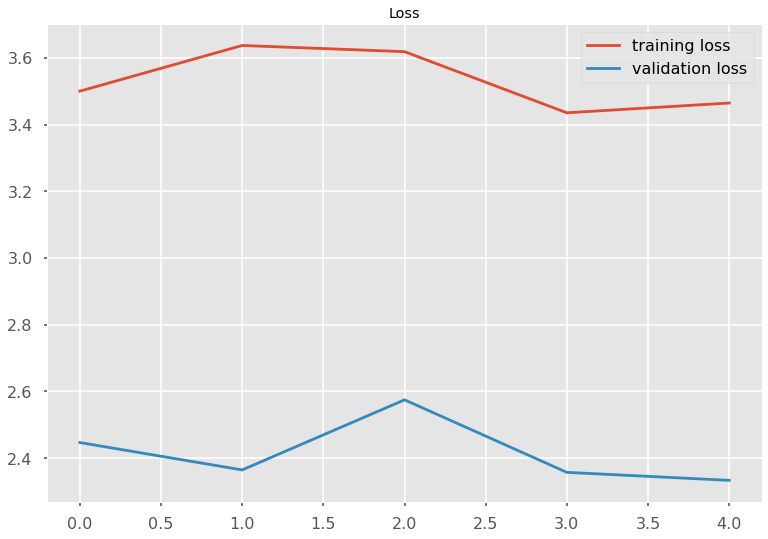

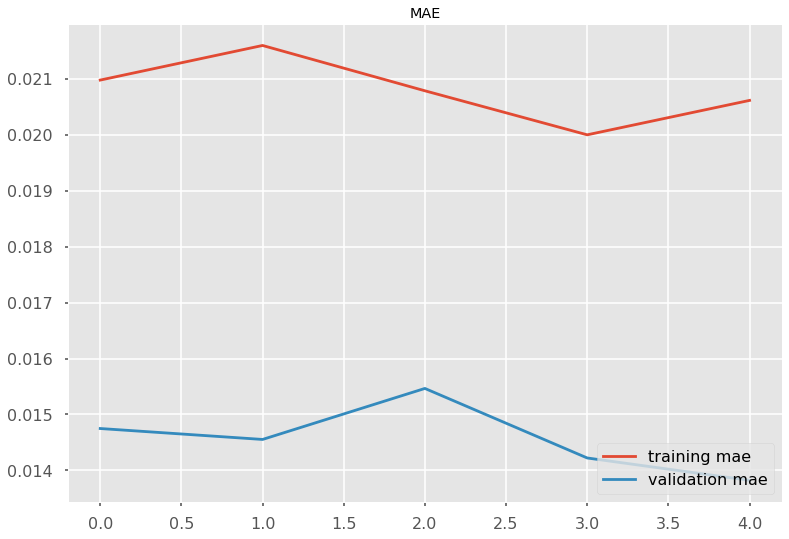

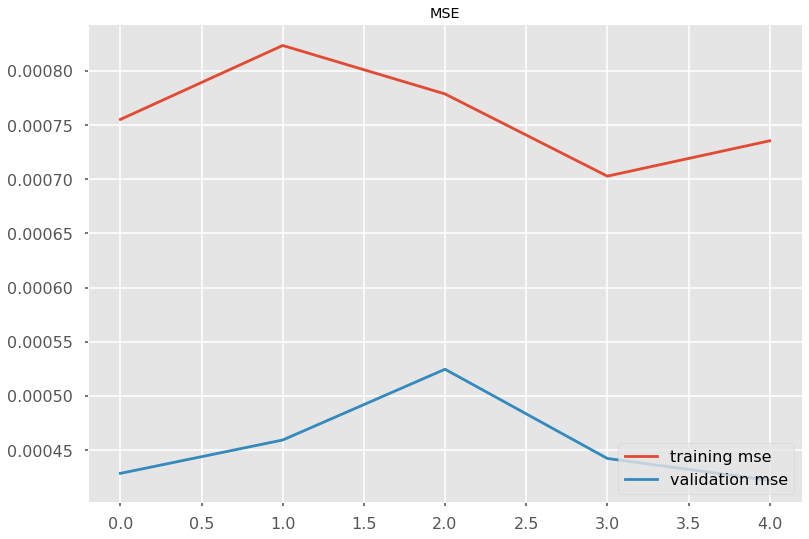

In [ ]:
plot_loss(history)
plot_mae(history)
plot_mse(history)

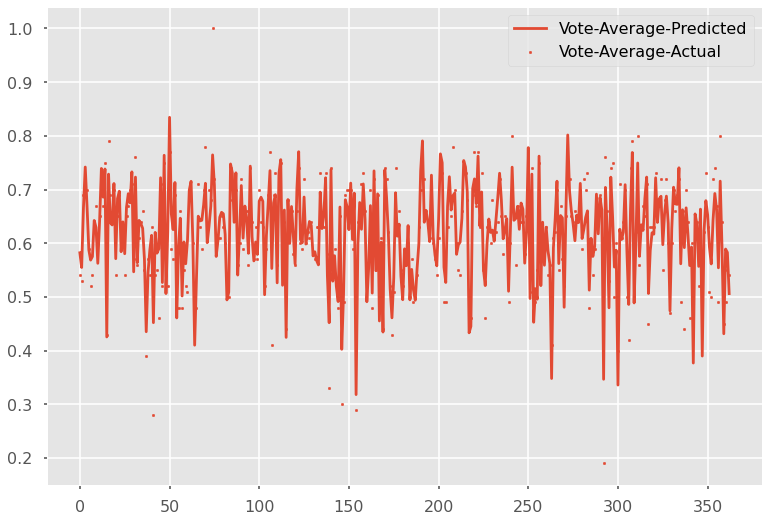

In [ ]:
import matplotlib.pyplot as plt
x_ax = range(len(X_img_val))
plt.scatter(x_ax, val_labels,  s=6, label="Vote-Average-Actual")
plt.plot(   x_ax, preds     ,       label="Vote-Average-Predicted")
plt.legend()
plt.show()

In [ ]:
print(cvsLoss)
print(cvsMAE)
print(cvsMSE)

['loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss']
['mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae']
['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse']


In [ ]:
es = EarlyStopping(monitor='val_mse',patience=10)
csv_logger = CSVLogger('model_history_log_model_lstm.csv', append=True)
check_point = ModelCheckpoint(filepath='best_lstm_model_todate', save_best_only=True, save_weights_only=True)

In [ ]:
stacked_model7_linear_model = stacked_model7.fit([X_img_train, X_text_train,X_categ_train], 
                                                 train_labels, 
                                                 batch_size=100, 
                                                 epochs=50,
                                                 validation_data=([X_img_test, X_text_test,X_categ_test], test_labels), ###USE TEST HERE
                                                 callbacks = [csv_logger, check_point])  ###removed the Early stopping par

Train on 3261 samples, validate on 907 samples
Epoch 1/50
3261/3261 [==============================] - 689s 211ms/step - loss: 25.3095 - mae: 0.1525 - mse: 0.0466 - val_loss: 10.1874 - val_mae: 0.0601 - val_mse: 0.0052
Epoch 2/50
3261/3261 [==============================] - 683s 210ms/step - loss: 13.0266 - mae: 0.0776 - mse: 0.0096 - val_loss: 8.2234 - val_mae: 0.0488 - val_mse: 0.0035
Epoch 3/50
3261/3261 [==============================] - 684s 210ms/step - loss: 11.6506 - mae: 0.0693 - mse: 0.0077 - val_loss: 6.0135 - val_mae: 0.0348 - val_mse: 0.0020
Epoch 4/50
3261/3261 [==============================] - 685s 210ms/step - loss: 11.2296 - mae: 0.0661 - mse: 0.0069 - val_loss: 6.2059 - val_mae: 0.0353 - val_mse: 0.0021
Epoch 5/50
3261/3261 [==============================] - 683s 210ms/step - loss: 10.3007 - mae: 0.0606 - mse: 0.0059 - val_loss: 5.5317 - val_mae: 0.0316 - val_mse: 0.0017
Epoch 6/50
3261/3261 [==============================] - 684s 210ms/step - loss: 10.0660 - mae: 0.

In [ ]:
print("[INFO] predicting avg votes...")
preds = stacked_model7.predict([X_img_val, X_text_val,X_categ_val])
diff = preds.flatten() - val_labels
percentDiff = (diff / val_labels) * 100
absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)



[INFO] predicting avg votes...


In [ ]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
print('mean_absolute_error = ',mean_absolute_error(val_labels, preds))
print('mean_squared_error  = ',mean_squared_error(val_labels, preds))
print('r2_score            = ',r2_score(val_labels, preds))

mean_absolute_error =  0.030173726896280752
mean_squared_error  =  0.0017116981987668992
r2_score            =  0.8225868373943258


In [ ]:
def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_acc(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
  plt.show()

In [ ]:
final_predictions=list(zip(preds.flatten(),val_labels))
type(final_predictions)
df=pd.DataFrame(final_predictions, columns=['predicted','actual'])
df['error']= df['actual'].sub(df['predicted'], axis = 0)
df

,predicted,actual,error
0,0.572141,0.54,-0.032141
1,0.553942,0.53,-0.023942
2,0.677609,0.69,0.012391
3,0.749652,0.70,-0.049652
4,0.678041,0.70,0.021959
...,...,...,...
358,0.606943,0.64,0.033057
359,0.431590,0.45,0.018410
360,0.586147,0.49,-0.096147
361,0.628797,0.55,-0.078797


In [ ]:
df['actual']     = df['actual']*10
df['predicted']  = df['predicted']*10
df['error']      = df['error']*10
df['abs_error'] = df['error'].abs()
df

,predicted,actual,error,abs_error
0,5.721415,5.4,-0.321415,0.321415
1,5.539416,5.3,-0.239416,0.239416
2,6.776088,6.9,0.123912,0.123912
3,7.496516,7.0,-0.496516,0.496516
4,6.780410,7.0,0.219590,0.219590
...,...,...,...,...
358,6.069427,6.4,0.330573,0.330573
359,4.315900,4.5,0.184100,0.184100
360,5.861470,4.9,-0.961470,0.961470
361,6.287971,5.5,-0.787971,0.787971


In [ ]:
df.loc[:,"abs_error"].mean()

0.31005180532282045

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
print('mean_absolute_error = ',mean_absolute_error(val_labels, preds))
print('mean_squared_error  = ',mean_squared_error(val_labels, preds))
print('r2_score            = ',r2_score(val_labels, preds))


mean_absolute_error =  0.03100518053228205
mean_squared_error  =  0.0017719365046488735
r2_score            =  0.8163432902758981


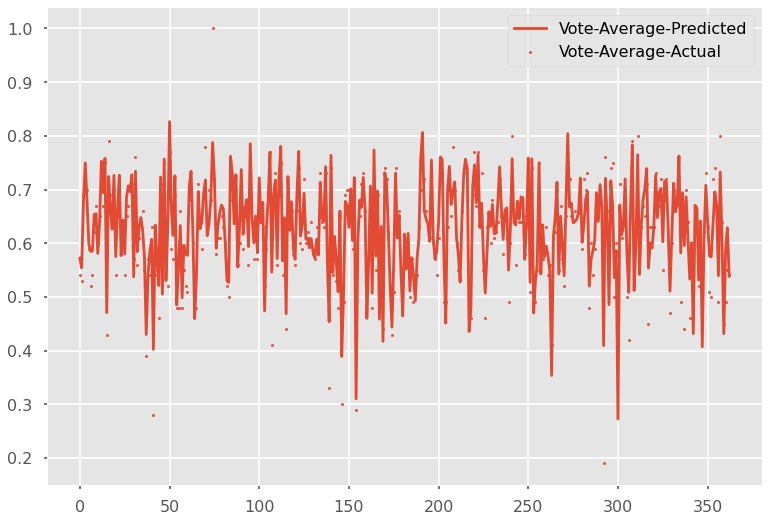

In [ ]:
import matplotlib.pyplot as plt
x_ax = range(len(X_img_val))
plt.scatter(x_ax, val_labels,  s=6, label="Vote-Average-Actual")
plt.plot(   x_ax, preds     ,       label="Vote-Average-Predicted")
plt.legend()
plt.show()

In [ ]:
stacked_model7.save('OnlyVAG_stacked_model7_July15_2020.h5')

In [ ]:
from keras.models import Model, load_model
history = load_model("MovieGen/MovieGenPosters/New_Approach_7/OnlyVAG_stacked_model7_July15_2020.h5")

Using TensorFlow backend.


In [ ]:
def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_mse'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()



In [ ]:
__version__

NameError: name '__version__' is not defined

In [ ]:
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional

def compile_model_TEXT_ONLY(embedding_matrix):
  lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=MAX_SEQUENCE_LENGTH, trainable=False)(lstm_input)
  ###x = Dropout(0.3)(x)
  ###x = LSTM(64, return_sequences = True)(x)
  x = Bidirectional(LSTM(75))(x)
  ###x = Dropout(0.3)(x)
  ###x = LSTM(64)(x)
  x = Dense(32,activation = 'relu')(x)
  ###x = Dropout(0.3)(x)
  output = Dense(1, activation = 'linear')(x)

  model = Model(inputs=[lstm_input], outputs=[output])
  adam = Adam(lr=1e-3, decay=1e-3 / 200) ###Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mae','mse'])
  return model

In [ ]:
textOnly_model = compile_model_TEXT_ONLY(word2vec_embedding_matrix)
textOnly_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 8190)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 8190, 300)         16923600  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 150)               225600    
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4832      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 17,154,065
Trainable params: 230,465
Non-trainable params: 16,923,600
_________________________________________________________________


In [ ]:
word2vec_multi_modal_model = textOnly_model.fit([X_text_train], train_labels, 
                                                batch_size=50, 
                                                epochs=10,
                                                validation_data=([X_text_val], val_labels))
                                                ###callbacks = [es, csv_logger, check_point])

Train on 3261 samples, validate on 363 samples
Epoch 1/10
3261/3261 [==============================] - 953s 292ms/step - loss: 25.7708 - mae: 0.1529 - mse: 0.0513 - val_loss: 14.5681 - val_mae: 0.0856 - val_mse: 0.0115
Epoch 2/10
3261/3261 [==============================] - 933s 286ms/step - loss: 13.3354 - mae: 0.0751 - mse: 0.0093 - val_loss: 14.3603 - val_mae: 0.0784 - val_mse: 0.0102
Epoch 3/10
3261/3261 [==============================] - 960s 294ms/step - loss: 12.5899 - mae: 0.0710 - mse: 0.0087 - val_loss: 14.3265 - val_mae: 0.0803 - val_mse: 0.0105
Epoch 4/10
3261/3261 [==============================] - 946s 290ms/step - loss: 12.1506 - mae: 0.0688 - mse: 0.0082 - val_loss: 14.2536 - val_mae: 0.0809 - val_mse: 0.0107
Epoch 5/10
3261/3261 [==============================] - 944s 290ms/step - loss: 11.8628 - mae: 0.0670 - mse: 0.0078 - val_loss: 14.3588 - val_mae: 0.0801 - val_mse: 0.0105
Epoch 6/10
3261/3261 [==============================] - 936s 287ms/step - loss: 11.2407 - mae

In [ ]:
score = word2vec_model.evaluate(X_text_val, val_labels, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 14.717759996734703
Test accuracy: 0.002754820976406336


In [ ]:
print("[INFO] predicting avg votes...")
preds = word2vec_model.predict([X_text_test])
diff = preds.flatten() - test_labels
percentDiff = (diff / test_labels) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

##print(diff,percentDiff,absPercentDiff)

##print(mean,std)
##print(diff)
##print(preds*10,test_labels*10)





[INFO] predicting avg votes...


,predicted,actual,error
0,0.581075,0.64,0.058925
1,0.581943,0.47,-0.111943
2,0.586580,0.74,0.153420
3,0.597936,0.70,0.102064
4,0.586207,0.66,0.073793
...,...,...,...
902,0.608040,0.56,-0.048040
903,0.595633,0.57,-0.025633
904,0.557701,0.50,-0.057701
905,0.608569,0.71,0.101431


In [ ]:
final_predictions=list(zip(preds.flatten(),test_labels))
type(final_predictions)
df=pd.DataFrame(final_predictions, columns=['predicted','actual'])
df['error']= df['actual'].sub(df['predicted'], axis = 0)
df

,predicted,actual,error
0,0.581075,0.64,0.058925
1,0.581943,0.47,-0.111943
2,0.586580,0.74,0.153420
3,0.597936,0.70,0.102064
4,0.586207,0.66,0.073793
...,...,...,...
902,0.608040,0.56,-0.048040
903,0.595633,0.57,-0.025633
904,0.557701,0.50,-0.057701
905,0.608569,0.71,0.101431


In [ ]:
df['actual']     = df['actual']*10
df['predicted']  = df['predicted']*10
df['error']      = df['error']*10
df['abs_error'] = df['error'].abs()
df[['abs_error']].mean(axis=1)

0      0.589252
1      1.119430
2      1.534200
3      1.020636
4      0.737931
         ...   
902    0.480400
903    0.256331
904    0.577011
905    1.014311
906    0.810668
Length: 907, dtype: float64

In [ ]:
df.loc[:,"abs_error"].mean()

0.8039577743841505

In [ ]:
corrrelation    = df.corr(method="pearson");
print("Pearson correlation coefficient:");
print(corrrelation);


Pearson correlation coefficient:
           predicted    actual     error
predicted   1.000000 -0.045796 -0.379232
actual     -0.045796  1.000000  0.941698
error      -0.379232  0.941698  1.000000


In [ ]:
corrrelation    = df.corr(method="kendall");
print("Kendall Tau correlation coefficient:");
print(corrrelation);
 

Kendall Tau correlation coefficient:
           predicted    actual     error
predicted   1.000000 -0.034027 -0.184770
actual     -0.034027  1.000000  0.862506
error      -0.184770  0.862506  1.000000


In [ ]:
def compile_model_IMG_ONLY():

  print(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
  cnn_input = Input(shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))
  y = Conv2D(32, (3, 3), activation='relu', input_shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))(cnn_input)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(64, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Flatten()(y)
  y = Dropout(0.3)(y)
  y = Dense(512, activation='relu')(y)
  output = Dense(1, activation='sigmoid')(y)

  model = Model(inputs=[cnn_input], outputs=[output])
  adam = Adam(lr=1e-3, decay=1e-3 / 200) ###Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['accuracy'])
  return model

In [ ]:
imgonly_model = compile_model_IMG_ONLY()
imgonly_model.summary()

115 75 3
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 115, 75, 3)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 113, 73, 32)       896       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 56, 36, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 54, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 27, 17, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 25, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 12, 7, 128)  

In [ ]:
imgONLY_model = imgonly_model.fit([X_img_train], train_labels, 
                                                batch_size=100, 
                                                epochs=10,
                                                validation_data=([X_img_val], val_labels), 
                                                callbacks = [es, csv_logger, check_point])

Train on 3261 samples, validate on 363 samples
Epoch 1/10
3261/3261 [==============================] - 1s 389us/step - loss: 16.5279 - accuracy: 6.1331e-04 - val_loss: 14.7111 - val_accuracy: 0.0028
Epoch 2/10
3261/3261 [==============================] - 1s 289us/step - loss: 13.7285 - accuracy: 6.1331e-04 - val_loss: 14.0976 - val_accuracy: 0.0028
Epoch 3/10
3261/3261 [==============================] - 1s 289us/step - loss: 13.6267 - accuracy: 6.1331e-04 - val_loss: 14.0198 - val_accuracy: 0.0028
Epoch 4/10
3261/3261 [==============================] - 1s 291us/step - loss: 13.7070 - accuracy: 6.1331e-04 - val_loss: 14.0260 - val_accuracy: 0.0028
Epoch 5/10
3261/3261 [==============================] - 1s 288us/step - loss: 13.5012 - accuracy: 6.1331e-04 - val_loss: 14.0617 - val_accuracy: 0.0028
Epoch 6/10
3261/3261 [==============================] - 1s 288us/step - loss: 13.4365 - accuracy: 6.1331e-04 - val_loss: 14.0195 - val_accuracy: 0.0028
Epoch 7/10
3261/3261 [===================

In [ ]:
def compile_model_CATEG_ONLY():

  print(X_categ_train.shape[1])
  cnn2_input = Input(shape=(X_categ_train.shape[1],))
  p = Dense(4, activation='relu')(cnn2_input)
  ###p = Dropout(0.3)(p)
  p = Dense(50, activation='relu')(cnn2_input)
  ###p = Dropout(0.3)(p)
  p = Dense(25, activation='relu')(cnn2_input)
  ###p = Dropout(0.3)(p)    
  output = Dense(1, activation='linear')(p)

  model = Model(inputs=[cnn2_input], outputs=[output])
  adam = Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['accuracy'])
  return model

In [ ]:
categonly_model = compile_model_CATEG_ONLY()
categonly_model.summary()

4
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_88 (Dense)             (None, 25)                125       
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 26        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [ ]:
categONLY_model = categonly_model.fit([X_categ_train], train_labels, 
                                                batch_size=10, 
                                                epochs=10,
                                                validation_data=([X_categ_val], val_labels), 
                                                callbacks = [es, csv_logger, check_point])

Train on 3261 samples, validate on 363 samples
Epoch 1/10
3261/3261 [==============================] - 1s 220us/step - loss: 10.9254 - accuracy: 6.1331e-04 - val_loss: 5.9202 - val_accuracy: 0.0028
Epoch 2/10
3261/3261 [==============================] - 1s 200us/step - loss: 5.8165 - accuracy: 6.1331e-04 - val_loss: 6.5287 - val_accuracy: 0.0028
Epoch 3/10
3261/3261 [==============================] - 1s 192us/step - loss: 5.7300 - accuracy: 6.1331e-04 - val_loss: 5.3108 - val_accuracy: 0.0028
Epoch 4/10
3261/3261 [==============================] - 1s 193us/step - loss: 5.6312 - accuracy: 6.1331e-04 - val_loss: 5.2613 - val_accuracy: 0.0028
Epoch 5/10
3261/3261 [==============================] - 1s 192us/step - loss: 5.6340 - accuracy: 6.1331e-04 - val_loss: 5.2478 - val_accuracy: 0.0028
Epoch 6/10
3261/3261 [==============================] - 1s 191us/step - loss: 5.6106 - accuracy: 6.1331e-04 - val_loss: 5.3111 - val_accuracy: 0.0028
Epoch 7/10
3261/3261 [==============================

In [ ]:
print("[INFO] predicting avg votes...")
preds = categonly_model.predict([X_categ_test])
diff = preds.flatten() - test_labels
percentDiff = (diff / test_labels) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

##print(diff,percentDiff,absPercentDiff)

##print(mean,std)
##print(diff)
##print(preds*10,test_labels*10)
final_predictions=list(zip(preds.flatten(),test_labels))
type(final_predictions)
df=pd.DataFrame(final_predictions, columns=['predicted','actual'])
df['error']= df['actual'].sub(df['predicted'], axis = 0)
df

[INFO] predicting avg votes...


,predicted,actual,error
0,0.633266,0.64,0.006734
1,0.481867,0.47,-0.011867
2,0.725932,0.74,0.014068
3,0.646646,0.70,0.053354
4,0.596564,0.66,0.063436
...,...,...,...
902,0.543781,0.56,0.016219
903,0.575756,0.57,-0.005756
904,0.500393,0.50,-0.000393
905,0.680720,0.71,0.029280


In [ ]:
val_labels.shape

(363, 18)

In [ ]:
es = EarlyStopping(patience=5)
csv_logger = CSVLogger('model_history_log_model_lstm.csv', append=True)
check_point = ModelCheckpoint(filepath='best_lstm_model_todate', save_best_only=True, save_weights_only=True)

In [ ]:
word2vec_multi_modal_model = word2vec_model.fit([X_img_train, X_text_train,X_categ_train], train_labels, batch_size=100, epochs=20,
                            validation_data=([X_img_val, X_text_val,X_val_categ], val_labels), callbacks = [es, csv_logger, check_point])

Train on 3261 samples, validate on 363 samples
Epoch 1/20
3261/3261 [==============================] - 653s 200ms/step - loss: 0.6195 - accuracy: 0.8406 - val_loss: 0.4560 - val_accuracy: 0.8604
Epoch 2/20
 800/3261 [======>.......................] - ETA: 7:56 - loss: 0.5646 - accuracy: 0.8565

KeyboardInterrupt: 

In [ ]:
word2vec_model.save('base_model_word2vec_lstm.h5')

In [ ]:
word2vec_model = load_model("base_model_word2vec_lstm.h5")

In [ ]:
def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_acc(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
  plt.show()

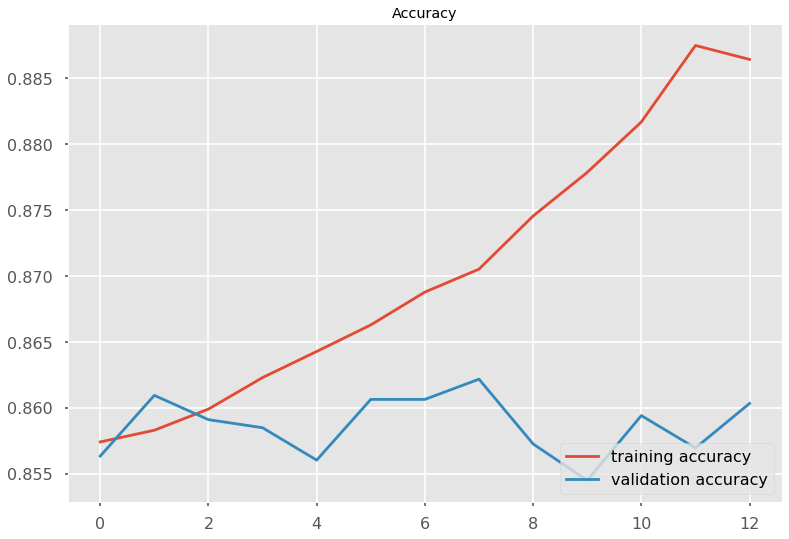

In [ ]:
plot_acc(word2vec_multi_modal_model)

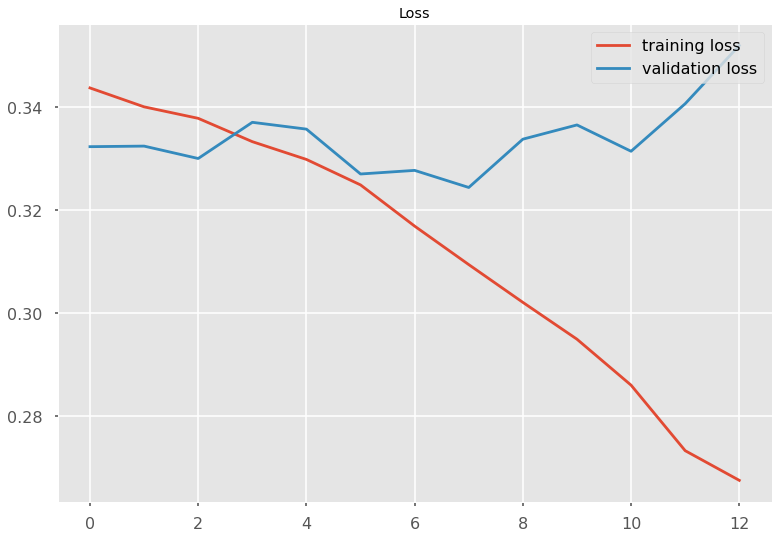

In [ ]:
plot_loss(word2vec_multi_modal_model)

In [ ]:
loss, acc = word2vec_model.evaluate([X_img_test, X_text_test], test_labels, batch_size=256)
print("word2vec model:", loss, acc)

453/453 [==============================] - 7s 15ms/step
word2vec model: 0.3431947094452039 0.8677948713302612


In [ ]:
out = word2vec_model.predict([X_img_test, X_text_test], batch_size=256)

In [ ]:

roc_auc = roc_auc_score(test_labels, out)
print(roc_auc)

0.6184858939477523
